In [1]:
import re
import os
import random
import numpy as np
import gc

In [2]:
train_file = open("/home/pavel/MyDocs/MachineLearning/Yandex_ML_project/lecture4/Kaggle_phonetics/train.txt","r")
train = train_file.read()
train = train.split('\n')
train = train[:-1]
print("Examples in test dataset:", len(train))
x_train = [data_example.split(' ')[0] for data_example in train]
y_train = [data_example.split(' ')[1] for data_example in train]

Examples in test dataset: 83194


In [3]:
x_train_copy = x_train.copy()
y_train_copy = y_train.copy()

In [4]:
x_train = x_train_copy[:83000]
y_train = y_train_copy[:83000]
x_test = x_train_copy[83000:]
y_test = y_train_copy[83000:]

In [5]:
def get_phonetic_dict(x, y):
    phonetic_dict = {}
    for i in range(len(x)):
        if x[i] not in phonetic_dict:
            phonetic_dict[x[i]] = []
        phonetic_dict[x[i]].append(y[i])
    return phonetic_dict

In [6]:
phonetic_dict = get_phonetic_dict(x_train, y_train)
example_count = np.sum([len(prons) for _, prons in phonetic_dict.items()])

In [7]:
print("\n".join([k+' --> '+phonetic_dict[k][0] for k in random.sample(list(phonetic_dict.keys()), 10)]))
print('\nAfter cleaning, the dictionary contains %s words and %s pronunciations (%s are alternate pronunciations).' % 
      (len(phonetic_dict), example_count, (example_count-len(phonetic_dict))))

POROUS --> P_AO_R_AH_S
WRUCK --> R_AH_K
LIGHTHALL --> L_AY_T_HH_AO_L
VARZI --> V_AA_R_Z_IY
BEAUTICIAN --> B_Y_UW_T_IH_SH_AH_N
DANNY'S --> D_AE_N_IY_Z
IGOE --> IY_G_OW
INUNDATIONS --> IH_N_AH_N_D_EY_SH_AH_N_Z
GLOTFELTY --> G_L_AA_T_F_IH_L_T_IY
WICHITA --> W_IH_CH_AH_T_AO

After cleaning, the dictionary contains 83000 words and 83000 pronunciations (0 are alternate pronunciations).


In [8]:
import string

START_PHONE_SYM = 's'
END_PHONE_SYM = 'e'


def char_list():
    allowed_symbols = ['']
    for word in x_train:
        for char in word:
            if char not in allowed_symbols:
                allowed_symbols.append(char)
    return allowed_symbols


def phone_list():
    phone_list = [START_PHONE_SYM, END_PHONE_SYM]
    for transcription in y_train:
        for phone in transcription.split('_'):
            if phone not in phone_list:
                phone_list.append(phone)
    return [''] + phone_list


def id_mappings_from_list(str_list):
    str_to_id = {s: i for i, s in enumerate(str_list)} 
    id_to_str = {i: s for i, s in enumerate(str_list)}
    return str_to_id, id_to_str


# Create character to ID mappings
char_to_id, id_to_char = id_mappings_from_list(char_list())

# Load phonetic symbols and create ID mappings
phone_to_id, id_to_phone = id_mappings_from_list(phone_list())

# Example:
print('Char to id mapping: \n', char_to_id)
print('Phone to id mapping: \n', phone_to_id)

Char to id mapping: 
 {'': 0, 'L': 1, 'E': 2, 'M': 3, 'I': 4, 'U': 5, 'X': 6, 'N': 7, 'D': 8, 'G': 9, 'S': 10, 'T': 11, 'R': 12, 'P': 13, 'K': 14, 'C': 15, 'O': 16, 'F': 17, 'A': 18, 'B': 19, 'H': 20, 'V': 21, 'Y': 22, 'W': 23, 'J': 24, "'": 25, 'Q': 26, 'Z': 27, '-': 28}
Phone to id mapping: 
 {'': 0, 's': 1, 'e': 2, 'L': 3, 'AH': 4, 'M': 5, 'Y': 6, 'UW': 7, 'AY': 8, 'N': 9, 'D': 10, 'IH': 11, 'NG': 12, 'S': 13, 'T': 14, 'R': 15, 'P': 16, 'K': 17, 'EH': 18, 'AA': 19, 'F': 20, 'ER': 21, 'EY': 22, 'AE': 23, 'Z': 24, 'G': 25, 'B': 26, 'SH': 27, 'V': 28, 'OW': 29, 'AO': 30, 'IY': 31, 'W': 32, 'HH': 33, 'JH': 34, 'CH': 35, 'TH': 36, 'AW': 37, 'OY': 38, 'UH': 39, 'ZH': 40, 'DH': 41}


In [9]:
CHAR_TOKEN_COUNT = len(char_to_id)
PHONE_TOKEN_COUNT = len(phone_to_id)


def char_to_1_hot(char):
    char_id = char_to_id[char]
    hot_vec = np.zeros((CHAR_TOKEN_COUNT))
    hot_vec[char_id] = 1.
    return hot_vec


def phone_to_1_hot(phone):
    phone_id = phone_to_id[phone]
    hot_vec = np.zeros((PHONE_TOKEN_COUNT))
    hot_vec[phone_id] = 1.
    return hot_vec

# Example:
print('"A" is represented by:\n', char_to_1_hot('A'), '\n-----')
print('"AH" is represented by:\n', phone_to_1_hot('AH'))
MAX_CHAR_SEQ_LEN = max([len(word) for word, _ in phonetic_dict.items()])
MAX_PHONE_SEQ_LEN = max([max([len(pron.split('_')) for pron in pronuns]) 
                         for _, pronuns in phonetic_dict.items()]
                       ) + 2  # + 2 to account for the start & end tokens we need to add

"A" is represented by:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] 
-----
"AH" is represented by:
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
def dataset_to_1_hot_tensors():
    char_seqs = []
    phone_seqs = []
    
    for word, pronuns in phonetic_dict.items():
        word_matrix = np.zeros((MAX_CHAR_SEQ_LEN, CHAR_TOKEN_COUNT))
        for t, char in enumerate(word):
            word_matrix[t, :] = char_to_1_hot(char)
        for pronun in pronuns:
            pronun_matrix = np.zeros((MAX_PHONE_SEQ_LEN, PHONE_TOKEN_COUNT))
            phones = [START_PHONE_SYM] + pronun.split('_') + [END_PHONE_SYM]
            for t, phone in enumerate(phones):
                pronun_matrix[t,:] = phone_to_1_hot(phone)
                
            char_seqs.append(word_matrix)
            phone_seqs.append(pronun_matrix)
    
    return np.array(char_seqs), np.array(phone_seqs)
            

char_seq_matrix, phone_seq_matrix = dataset_to_1_hot_tensors()        
print('Word Matrix Shape: ', char_seq_matrix.shape)
print('Pronunciation Matrix Shape: ', phone_seq_matrix.shape)

Word Matrix Shape:  (83000, 34, 29)
Pronunciation Matrix Shape:  (83000, 34, 42)


In [11]:
def dataset_for_embeddings():
    char_seqs = []
    phone_seqs = []
    
    for word,pronuns in phonetic_dict.items():
        word_matrix = np.zeros((MAX_CHAR_SEQ_LEN))
        for t,char in enumerate(word):
            word_matrix[t] = char_to_id[char]
        for pronun in pronuns:
            pronun_matrix = np.zeros((MAX_PHONE_SEQ_LEN))
            phones = [START_PHONE_SYM] + pronun.split('_') + [END_PHONE_SYM]
            for t, phone in enumerate(phones):
                pronun_matrix[t] = phone_to_id[phone]
                
            char_seqs.append(word_matrix)
            phone_seqs.append(pronun_matrix)
    
    return np.array(char_seqs), np.array(phone_seqs)

            
char_emb_matrix, phone_emb_matrix = dataset_for_embeddings()        

print('Embedding Word Matrix Shape: ', char_emb_matrix.shape)
print('Embedding Phoneme Matrix Shape: ', phone_emb_matrix.shape)

Embedding Word Matrix Shape:  (83000, 34)
Embedding Phoneme Matrix Shape:  (83000, 34)


In [12]:
phone_seq_matrix_decoder_output = np.pad(phone_seq_matrix,((0,0),(0,1),(0,0)), mode='constant')[:,1:,:]

In [13]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0

(char_input_train, char_input_test, 
 phone_input_train, phone_input_test, 
 phone_output_train, phone_output_test) = train_test_split(
    char_seq_matrix, phone_seq_matrix, phone_seq_matrix_decoder_output, 
    test_size=TEST_SIZE, random_state=42)

(emb_char_input_train, emb_char_input_test, 
 emb_phone_input_train, emb_phone_input_test) = train_test_split(
    char_emb_matrix, phone_emb_matrix, test_size=TEST_SIZE, random_state=42)

#### MODEL

In [14]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Embedding,Activation

def embedding_model(hidden_nodes = 256, emb_size = 256):
    
    # Shared Components - Encoder
    char_inputs = Input(shape=(None,))
    char_embedding_layer = Embedding(CHAR_TOKEN_COUNT, emb_size, input_length=MAX_CHAR_SEQ_LEN, mask_zero=True)
    encoder = LSTM(hidden_nodes, return_state=True, recurrent_dropout=0.1)
    
    # Shared Components - Decoder
    phone_inputs = Input(shape=(None,))
    phone_embedding_layer = Embedding(PHONE_TOKEN_COUNT, emb_size, mask_zero=True)
    decoder = LSTM(hidden_nodes, return_sequences=True, return_state=True, recurrent_dropout=0.1)
    decoder_dense = Dense(PHONE_TOKEN_COUNT, activation='softmax')
    
    # Training Model
    char_embeddings = char_embedding_layer(char_inputs)
    char_embeddings = Activation('relu')(char_embeddings)
    char_embeddings = Dropout(0.5)(char_embeddings)
    _, state_h, state_c = encoder(char_embeddings)
    encoder_states = [state_h, state_c]
    
    phone_embeddings = phone_embedding_layer(phone_inputs)
    phone_embeddings = Activation('relu')(phone_embeddings)
    phone_embeddings = Dropout(0.5)(phone_embeddings)
    decoder_outputs, _, _ = decoder(phone_embeddings, initial_state=encoder_states)
    decoder_outputs = Dropout(0.5)(decoder_outputs)
    phone_outputs = decoder_dense(decoder_outputs)

    training_model = Model([char_inputs, phone_inputs], phone_outputs)
    
    # Testing Model - Encoder
    testing_encoder_model = Model(char_inputs, encoder_states)
    
    # Testing Model - Decoder
    decoder_state_input_h = Input(shape=(hidden_nodes,))
    decoder_state_input_c = Input(shape=(hidden_nodes,))
    decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
    test_decoder_outputs, decoder_state_h, decoder_state_c = decoder(phone_embeddings, initial_state=decoder_state_inputs)
    decoder_states = [decoder_state_h, decoder_state_c]
    test_phone_outputs = decoder_dense(test_decoder_outputs)
    
    testing_decoder_model = Model([phone_inputs] + decoder_state_inputs, [test_phone_outputs] + decoder_states)
    
    return training_model, testing_encoder_model, testing_decoder_model

Using TensorFlow backend.


In [15]:
gc.collect()

0

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

def train(model, weights_path, encoder_input, decoder_input, decoder_output):
    checkpointer = ModelCheckpoint(filepath=weights_path, verbose=1, save_best_only=True)
    stopper = EarlyStopping(monitor='val_loss',patience=8)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    model.fit([encoder_input, decoder_input], decoder_output,
          batch_size=256,
          epochs=80,
          validation_split=0.02, # Keras will automatically create a validation set for us
          callbacks=[checkpointer, stopper])

In [94]:
EMBEDDING_MODEL_WEIGHTS = "/home/pavel/MyDocs/MachineLearning/Yandex_ML_project/lecture4/Kaggle_phonetics/embedding_model_weights.hdf5"
emb_training_model, emb_testing_encoder_model, emb_testing_decoder_model = embedding_model()
emb_training_model.load_weights(EMBEDDING_MODEL_WEIGHTS)

train(emb_training_model, EMBEDDING_MODEL_WEIGHTS, emb_char_input_train, emb_phone_input_train, phone_output_train)

Train on 81340 samples, validate on 1660 samples
Epoch 1/80
81340/81340 [==============================] - 353s 4ms/step - loss: 0.1908 - val_loss: 0.1653

Epoch 00001: val_loss improved from inf to 0.16534, saving model to /home/pavel/MyDocs/MachineLearning/Yandex_ML_project/lecture4/Kaggle_phonetics/embedding_model_weights.hdf5


/home/pavel/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/network.py:888: UserWarning: Layer lstm_16 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_15/while/Exit_3:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_15/while/Exit_4:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/80
81340/81340 [==============================] - 368s 5ms/step - loss: 0.1889 - val_loss: 0.1666

Epoch 00002: val_loss did not improve from 0.16534
Epoch 3/80
81340/81340 [==============================] - 340s 4ms/step - loss: 0.1875 - val_loss: 0.1654

Epoch 00003: val_loss did not improve from 0.16534
Epoch 4/80
81340/81340 [==============================] - 361s 4ms/step - loss: 0.1861 - val_loss: 0.1664

Epoch 00004: val_loss did not improve from 0.16534
Epoch 5/80
81340/81340 [==============================] - 342s 4ms/step - loss: 0.1850 - val_loss: 0.1667

Epoch 00005: val_loss did not improve from 0.16534
Epoch 6/80
 8448/81340 [==>...........................] - ETA: 5:06 - loss: 0.1791

KeyboardInterrupt: 

In [58]:
def id_vec_to_word(emb_char_seq):
    word = ''
    for char_id in emb_char_seq[0]:
        char = id_to_char[char_id]
        word += char
    return word.strip()

In [59]:
def predict_emb(input_char_seq, encoder, decoder):
    state_vectors = encoder.predict(input_char_seq) 
    output_phone_seq = np.array([[phone_to_id[START_PHONE_SYM]]])
    
    end_found = False 
    pronunciation = '' 
    while not end_found:
        decoder_output, h, c = decoder.predict([output_phone_seq] + state_vectors)
        
        # Predict the phoneme with the highest probability
        predicted_phone_idx = np.argmax(decoder_output[0, -1, :])
        predicted_phone = id_to_phone[predicted_phone_idx]
        
        pronunciation += predicted_phone + '_'
        
        if predicted_phone == END_PHONE_SYM or len(pronunciation.split()) > MAX_PHONE_SEQ_LEN: 
            end_found = True
        
        # Setup inputs for next time step
        output_phone_seq = np.array([[predicted_phone_idx]])
        state_vectors = [h, c]
        
    return pronunciation.strip('_')

In [60]:
def evaluate(test_examples, encoder, decoder, word_decoder, predictor):
    perfect_predictions = 0
    
    for example_idx in range(TEST_EXAMPLE_COUNT):
        example_char_seq = test_examples[example_idx:example_idx+1]
        predicted_pronun = predictor(example_char_seq, encoder, decoder)
        example_word = word_decoder(example_char_seq)
        
        perfect_predictions += is_correct(example_word,predicted_pronun)
        correct_syllable_counts += is_syllable_count_correct(example_word,predicted_pronun)

        
    perfect_acc = perfect_predictions / TEST_EXAMPLE_COUNT

    return syllable_acc, perfect_acc, avg_bleu_scor

In [61]:
def get_accuracy(x_data, y_data):
    char_seqs = []
    
    for word in x_data:
        word_matrix = np.zeros((MAX_CHAR_SEQ_LEN))
        for t, char in enumerate(word):
            word_matrix[t] = char_to_id[char]
        char_seqs.append(word_matrix)

    char_seq_matrix_test = np.array(char_seqs)
    
    y_predicted = []
    for i in range(len(char_seq_matrix_test)):
        example_char_seq = char_seq_matrix_test[i:i+1]
        predicted_pronun = predict_emb(example_char_seq, emb_testing_encoder_model, emb_testing_decoder_model)
        predicted_pronun = predicted_pronun[:-2] #strip _e symbol
        
        if i % 100 == 0:
            print(i, '/', len(char_seq_matrix_test))
            print("Word:", x_data[i])
            print("Transcription:", y_data[i])
            print("Prediction:", predicted_pronun)
            
        y_predicted.append(predicted_pronun)
    correct_num = 0
    for i in range(len(x_data)):
        if y_data[i] == y_predicted[i]:
            correct_num += 1
    
    print("Prediction finished!!!")
    return correct_num/len(x_data)

In [90]:
print("Accuracy on train:", get_accuracy(x_train[:1000], y_train[:1000]))

0 / 1000
Word: LEMIEUX
Transcription: L_AH_M_Y_UW
Prediction: L_EH_M_Y_UW
100 / 1000
Word: DISSENT
Transcription: D_IH_S_EH_N_T
Prediction: D_IH_S_EH_N_T
200 / 1000
Word: ROACHE
Transcription: R_OW_CH
Prediction: R_OW_CH
300 / 1000
Word: MERCHANTS
Transcription: M_ER_CH_AH_N_T_S
Prediction: M_ER_CH_AH_N_T_S
400 / 1000
Word: ABBASI
Transcription: AA_B_AA_S_IY
Prediction: AH_B_AA_S_IY
500 / 1000
Word: HICKORY
Transcription: HH_IH_K_ER_IY
Prediction: HH_IH_K_ER_IY
600 / 1000
Word: SUBDIVIDE
Transcription: S_AH_B_D_AH_V_AY_D
Prediction: S_AH_B_D_IH_V_AY_D
700 / 1000
Word: ATTESTING
Transcription: AH_T_EH_S_T_IH_NG
Prediction: AH_T_EH_S_T_IH_NG
800 / 1000
Word: RARITAN
Transcription: R_EH_R_IH_T_AH_N
Prediction: R_EH_R_IH_T_AH_N
900 / 1000
Word: STUDLEY
Transcription: S_T_AH_D_L_IY
Prediction: S_T_AH_D_L_IY
Prediction finished!!!
Accuracy on train: 0.717


In [95]:
x_test = x_train_copy[83000:]
y_test = y_train_copy[83000:]
print("Accuracy on test:", get_accuracy(x_test, y_test))

0 / 194
Word: SAMANTHA
Transcription: S_AH_M_AE_N_TH_AH
Prediction: S_AH_M_AE_N_TH_AH
100 / 194
Word: DISDAINED
Transcription: D_IH_S_D_EY_N_D
Prediction: D_IH_S_D_EY_N_D
Prediction finished!!!
Accuracy on test: 0.6804123711340206


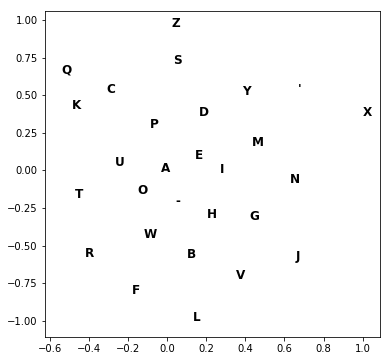

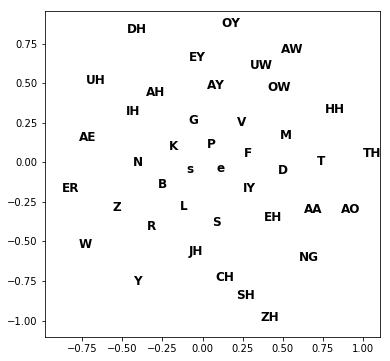

In [78]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def plot_embeddings(embeddings, symbols, perplexity):
    embeddings_in_2D = TSNE(n_components=2,perplexity=perplexity).fit_transform(embeddings)
    embeddings_in_2D[:,0] = embeddings_in_2D[:,0] / np.max(np.abs(embeddings_in_2D[:,0]))
    embeddings_in_2D[:,1] = embeddings_in_2D[:,1] / np.max(np.abs(embeddings_in_2D[:,1]))

    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)
    ax.scatter(embeddings_in_2D[:,0], embeddings_in_2D[:,1],c='w')

    for i, letter in enumerate(symbols):
        ax.annotate(letter, (embeddings_in_2D[i,0],embeddings_in_2D[i,1]), fontsize=12, fontweight='bold')
        
        
char_embedding = emb_training_model.layers[2].get_weights()[0]
plot_embeddings(char_embedding, char_to_id.keys(), 5)

phone_embedding = emb_training_model.layers[3].get_weights()[0]
plot_embeddings(phone_embedding, phone_to_id.keys(), 18)

#### Test the model:

In [79]:
gc.collect()

5862

In [80]:
import pandas as pd

In [96]:
test_data = pd.read_csv("/home/pavel/MyDocs/MachineLearning/Yandex_ML_project/lecture4/Kaggle_phonetics/test.csv")
x_test = list(test_data['Word'])

In [97]:
char_seqs = []
    
for word in x_test:
    word_matrix = np.zeros((MAX_CHAR_SEQ_LEN))
    for t, char in enumerate(word):
        word_matrix[t] = char_to_id[char]
    char_seqs.append(word_matrix)

char_seq_matrix_test = np.array(char_seqs)

In [98]:
print(len(char_seq_matrix_test))
print(char_seq_matrix_test.shape)

41597
(41597, 34)


In [99]:
y_test = []
for i in range(len(char_seq_matrix_test)):
    example_char_seq = char_seq_matrix_test[i:i+1]
    predicted_pronun = predict_emb(example_char_seq, emb_testing_encoder_model, emb_testing_decoder_model)
    predicted_pronun = predicted_pronun[:-2] #strip _e symbol
        
    if i % 1000 == 0:
        print(i, '/', len(char_seq_matrix_test))
            
    y_test.append(predicted_pronun)

0 / 41597
1000 / 41597
2000 / 41597
3000 / 41597
4000 / 41597
5000 / 41597
6000 / 41597
7000 / 41597
8000 / 41597
9000 / 41597
10000 / 41597
11000 / 41597
12000 / 41597
13000 / 41597
14000 / 41597
15000 / 41597
16000 / 41597
17000 / 41597
18000 / 41597
19000 / 41597
20000 / 41597
21000 / 41597
22000 / 41597
23000 / 41597
24000 / 41597
25000 / 41597
26000 / 41597
27000 / 41597
28000 / 41597
29000 / 41597
30000 / 41597
31000 / 41597
32000 / 41597
33000 / 41597
34000 / 41597
35000 / 41597
36000 / 41597
37000 / 41597
38000 / 41597
39000 / 41597
40000 / 41597
41000 / 41597


In [100]:
print(x_test[:10])
print(y_test[:10])

['PITCHED', 'DISSOLVERS', 'SCRAWNY', 'BONENFANT', 'EXCEEDS', 'BARTNICKI', 'BUTE', 'CAPITULATE', 'STEAM', 'INVESTCORP']
['P_IH_CH_T', 'D_IH_S_AA_L_V_ER_Z', 'S_K_R_AO_N_IY', 'B_OW_N_AH_N_F_AE_N_T', 'IH_K_S_IY_D_Z', 'B_AA_R_T_N_IH_T_S_K_IY', 'B_Y_UW_T', 'K_AE_P_IH_T_Y_AH_L_EY_T', 'S_T_IY_M', 'IH_N_V_EH_S_T_K_AO_R_P']


In [101]:
submission = pd.read_csv("/home/pavel/MyDocs/MachineLearning/Yandex_ML_project/lecture4/Kaggle_phonetics/test.csv")
submission['Word'] = y_test

In [102]:
print(submission.head())

   Id                  Word
0   1             P_IH_CH_T
1   2    D_IH_S_AA_L_V_ER_Z
2   3         S_K_R_AO_N_IY
3   4  B_OW_N_AH_N_F_AE_N_T
4   5         IH_K_S_IY_D_Z


In [104]:
submission.to_csv("/home/pavel/MyDocs/MachineLearning/Yandex_ML_project/lecture4/Kaggle_phonetics/submission_baseline_model2_embedding.csv")

In [74]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    
def bleu_score(word,test_pronunciation):
    references = [pronun.split('_') for pronun in phonetic_dict[word]]
    smooth = SmoothingFunction().method1
    return sentence_bleu(references, test_pronunciation.split('_'), smoothing_function=smooth)


def evaluate(test_examples, encoder, decoder, word_decoder, predictor):
    perfect_predictions = 0
    bleu_scores = []
    
    for example_idx in range(TEST_EXAMPLE_COUNT):
        example_char_seq = test_examples[example_idx:example_idx+1]
        predicted_pronun = predictor(example_char_seq, encoder, decoder)
        example_word = word_decoder(example_char_seq)
        
        perfect_predictions += is_correct(example_word,predicted_pronun)

        bleu = bleu_score(example_word,predicted_pronun)
        bleu_scores.append(bleu)
        
    perfect_acc = perfect_predictions / TEST_EXAMPLE_COUNT
    avg_bleu_score = np.mean(bleu_scores)
    
    return perfect_acc, avg_bleu_score


def print_results(model_name, perfect_acc, avg_bleu_score):
    print(model_name)
    print('-'*20)
    print('Perfect Accuracy: %s%%' % round(perfect_acc*100, 1))
    print('Bleu Score: %s' % round(avg_bleu_score, 4))


In [75]:
perfect_acc, avg_bleu_score = evaluate(
    char_input_test, testing_encoder_model, testing_decoder_model, one_hot_matrix_to_word, predict_baseline)
print_results('Baseline Model',perfect_acc, avg_bleu_score)

Baseline Model
--------------------
Perfect Accuracy: 0.0%
Bleu Score: 0.3248
